# Experiment for Random Feature Residual Learning

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
df=df.iloc[:1000] #smaller dataset
train,test = train_test_split(df, train_size=0.7,random_state=1)
train_y = train[0]
test_y = test[0] #response:year
train_x = train
test_x = test
del train_x[0]
del test_x[0]
total_x=pd.concat([train_x,test_x])
x=preprocessing.StandardScaler().fit(total_x).transform(total_x) #normalize
x=pd.DataFrame(x)
train_x=x.iloc[:700]
test_x=x.iloc[700:]
train_x ##display the data

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,-0.399249,0.835144,-0.622319,0.448003,2.007799,-0.587200,0.157608,0.162833,0.126620,0.934446,...,-0.175923,-0.338669,-0.294500,0.539363,0.134451,0.903267,-0.036479,0.058566,-0.467539,-0.356081
1,0.611410,1.031288,0.386663,0.080893,-1.171175,0.220171,0.075010,1.083187,-0.069954,0.450436,...,-0.682847,-0.270795,0.843590,-0.372357,-0.603993,0.040620,-0.021055,0.152383,-0.332274,-0.229677
2,-2.461032,-3.674868,-3.653136,1.236778,3.000675,-1.617221,-1.175166,-1.606176,2.924145,2.791427,...,0.167289,0.347161,-0.448494,0.432262,0.461041,-0.928082,0.481139,0.320794,-1.206054,0.877460
3,0.768204,0.499987,0.618442,0.232943,-0.586692,0.577788,-1.240398,-1.456485,1.882827,0.100002,...,-0.352490,-0.815609,-0.380686,-0.298919,-0.372729,-0.678564,-0.697738,-0.482907,-1.062682,-0.689911
4,-0.360145,0.453654,-0.856959,-1.112047,1.203026,-1.130459,0.061956,-0.051455,0.589049,1.053291,...,-0.189064,0.068835,-0.700625,0.279929,0.025462,0.178106,0.353471,0.154755,0.082733,0.273835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0.491281,0.404389,1.081376,2.247170,0.685369,2.604787,0.793695,-1.599761,1.066230,-1.613733,...,0.054296,-0.358425,1.391734,-0.223755,0.756662,1.033290,0.422683,1.795670,-1.443961,-0.090946
696,0.887955,1.159218,-0.379281,0.216746,0.099826,-0.510749,0.891885,1.108690,0.238704,0.770943,...,-0.938708,0.465857,-0.014701,-1.021187,-0.675124,0.001720,0.570214,0.450509,0.252772,-0.135660
697,1.402795,0.800784,0.364629,-0.644404,0.022042,-1.271532,0.874677,0.217202,-0.214492,-0.424945,...,-0.390672,0.574929,-0.172439,-0.627449,0.513539,-0.229768,0.006276,-0.118997,0.155934,-0.064517
698,-1.598520,-1.609621,0.987559,-0.134774,-0.474859,2.621075,-2.182424,1.602422,0.065120,1.055741,...,0.714872,-3.161457,0.513131,1.590477,-3.116020,-1.634228,1.598964,-1.394311,0.262776,0.995058


## DNN

In [13]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

In [24]:
class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len
    
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(90, 200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.9) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(400): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
            
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    dnn_trainloss.append(float(train_loss))
    dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=90, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 393184804864.0
            Test  set - loss: 601585418240.0
            
epoch 10
            Train set - loss: 310356416.0
            Test  set - loss: 445379040.0
            
epoch 20
            Train set - loss: 237992.8125
            Test  set - loss: 327638.28125
            
epoch 30
            Train set - loss: 339.2607727050781
            Test  set - loss: 249.12547302246094
            
epoch 40
            Train set - loss: 229.58665466308594
            Test  set - loss: 114.50023651123047
            
epoch 50
            Train set - loss: 196.45310974121094
            Test  set - loss: 110.24320983886719
            
epoch 60
            Train set - loss: 145.1417236328125
            

## Resnet

In [50]:
class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len
    
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,features):
        super(ResidualBlock,self).__init__()
        self.features = features
        
        self.fc1 = nn.Linear(features,features)
        self.fc2 = nn.Linear(features,features)
    
    def forward(self, x):
        y= F.relu(self.fc1(x))
        y = self.fc2(y)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.fc1 = nn.Linear(90,200)
        self.rblock1 = ResidualBlock(200)
        self.fc2 = nn.Linear(200,50)
        self.rblock2 = ResidualBlock(50)
        self.fc3 = nn.Linear(50,10)
        self.rblock3 = ResidualBlock(10)
        self.fc4 = nn.Linear(10,1)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.rblock1(x)
        x = F.relu(self.fc2(x))
        x = self.rblock2(x)
        x = F.relu(self.fc3(x))
        x = self.rblock3(x)
        return self.fc4(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.9) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(400): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
            
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    res_trainloss.append(float(train_loss))
    res_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (fc1): Linear(in_features=90, out_features=200, bias=True)
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=200, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
  )
  (fc2): Linear(in_features=200, out_features=50, bias=True)
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=50, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (rblock3): ResidualBlock(
    (fc1): Linear(in_features=10, out_features=10, bias=True)
    (fc2): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 8.016832476524307e+23
            Test  set - loss: 1.2281564061962833e+24
            
epoch 10
            Train set - loss: 6.332013929024318e+20
            Test  set - loss: 9.098471738064073e+20
            
epoch 20
            Trai

dropout: self.drop1=nn.Dropout(p=0.5)

## Random Feature

definition of random feature

In [16]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=np.random.randn(1)*gamma
        return w
    elif pdf=='L':
        w=np.random.laplace(1)*gamma
        return w
    elif pdf=='C':
        w=np.random.standard_cauchy(1)*gamma
        return w
    

def sample(pdf, gamma, d):
    return [sample_1d(pdf, gamma) for _ in range(d)]


class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : np.array
        shape (D,d)
    b : np.array
        shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    References
    ----------
    ..  [1] A. Rahimi, B. Recht, "Random Features for Large-Scale Kernel
        Machines"
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = np.random.uniform(0, 2 * np.pi, self.D)
        self.W = np.reshape(
            np.array([
                sample(self.kernel, self.gamma, self.d)
                for _ in range(self.D)], dtype=np.float32),
            (self.D, self.d))

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : np.array (shape=(n,d))
            Array to transform; must be single dimension vector
        Returns
        -------
        x : np.array (shape=(n,D))
            Feature space transformation of x
        """
        
        result=np.array([
            np.sqrt(2 / self.D) * np.cos(np.dot(self.W, x.iloc[i]) + self.b) for i in range(len(x))]
            )            
        return result

In [199]:
model =Ridge(alpha=1)
model.fit(train_x, train_y)
y_pretest=model.predict(test_x)
y_pretrain=model.predict(train_x)
print("LR train mse:",mean_squared_error(train_y,y_pretrain))
print("test mse:",mean_squared_error(test_y,y_pretest))

score=[]
trainmse=[]
testmse=[]
gaset=np.linspace(0,0.3,100)
for ga in gaset:
    rff=RandomFourierFeature(90,2000,kernel='G',gamma=ga)
    total_x=pd.concat([train_x,test_x])
    feature=rff.transform(total_x)
    train_xtransformed=feature[:len(train_x)]
    test_xtransformed=feature[len(train_x):]
    model.fit(train_xtransformed, train_y)
    y_pretest=model.predict(test_xtransformed)
    y_pretrain=model.predict(train_xtransformed)
    score.append(cross_val_score(model,train_xtransformed,train_y,cv=5).mean())   ##cross-validation
    trainmse.append(mean_squared_error(y_pretrain,train_y))
    testmse.append(mean_squared_error(y_pretest,test_y))
ind=score.index(max(score))
print("cv-score,index,gamma,trainmse,testmse",max(score),ind,gaset[ind],trainmse[ind],testmse[ind])

LR train mse: 101.34079619813826
test mse: 151.7788073684705
cv-score,index,gamma,trainmse,testmse 0.3383575673661757 53 0.1606060606060606 55.48120279607968 139.47580131279776


one single gaussian kernel machine

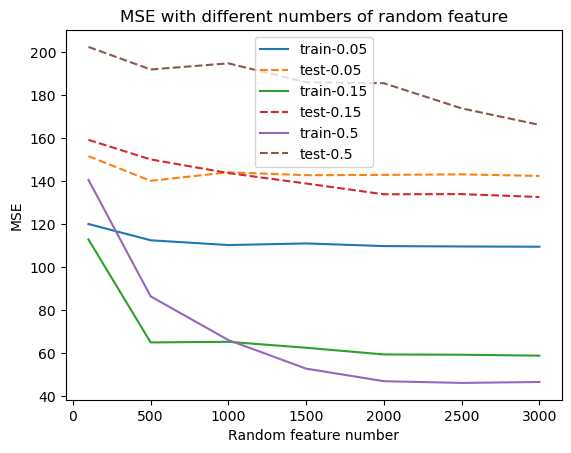

In [198]:
model=Ridge(alpha=1)
Layer=1
m0set=[100,500,1000,1500,2000,2500,3000]
gaset=[0.05,0.15,0.5]

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
        total_x=pd.concat([train_x,test_x])
        feature=rff.transform(total_x)
        train_xtransformed=feature[:700]
        test_xtransformed=feature[700:]
            
        model.fit(train_xtransformed, train_y)
        y_pretest=model.predict(test_xtransformed)
        y_pretrain=model.predict(train_xtransformed)
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number")
plt.ylabel("MSE")
plt.title("MSE with different numbers of random feature")
plt.legend(["train-0.05","test-0.05","train-0.15","test-0.15","train-0.5","test-0.5"])
plt.show()

## multilayer learning

In [47]:
class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len
    
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)


class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(200, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 1)
        
    def forward(self, x):
        rff=RandomFourierFeature(90,200,kernel='L',gamma=0.01)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x=self.fc1(x)
        rff=RandomFourierFeature(50,50,kernel='C',gamma=0.1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x=self.fc2(x)
        rff=RandomFourierFeature(10,10,kernel='G',gamma=1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.9) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(400): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    kernelnn_trainloss.append(float(train_loss))
    kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 1667508.625
            Test  set - loss: 1650703.5
            
epoch 10
            Train set - loss: 557.980224609375
            Test  set - loss: 85393.28125
            
epoch 20
            Train set - loss: 1180.32958984375
            Test  set - loss: 2037.85791015625
            
epoch 30
            Train set - loss: 141.26470947265625
            Test  set - loss: 436.4217224121094
            
epoch 40
            Train set - loss: 225.75083923339844
            Test  set - loss: 122.38993835449219
            
epoch 50
            Train set - loss: 131.2929229736328
            Test  set - loss: 110.80830383300781
            
epoch 60
            Train set - loss: 222.06431579589844
            Test  set - loss: 112.97732543945312
            

## Residual multilayer learning

In [42]:
class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len
    
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,features):
        super(ResidualBlock,self).__init__()
        self.features = features
        
        self.fc1 = nn.Linear(features,features)
        self.fc2 = nn.Linear(features,features)
    
    def forward(self, x):
        y = F.relu(self.fc1(x))
        y = self.fc2(y)
        return F.relu(x+y)

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(50)
        self.fc1 = nn.Linear(50, 50)
        self.rblock2 = ResidualBlock(100)
        self.fc2 = nn.Linear(100, 50)
        self.rblock3 = ResidualBlock(200)
        self.fc3 = nn.Linear(200, 1)
 
    def forward(self, x):
        rff=RandomFourierFeature(90,50,kernel='G',gamma=1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock1(x)
        x = self.fc1(x)
        rff=RandomFourierFeature(50,100,kernel='C',gamma=0.1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock2(x)
        x = self.fc2(x)
        rff=RandomFourierFeature(50,200,kernel='L',gamma=0.01)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock3(x)
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(400): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    reskernel_trainloss.append(float(train_loss))
    reskernel_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=50, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (rblock3): ResidualBlock(
    (fc1): Linear(in_features=200, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
  )
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 1224062.625
            Test  set - loss: 4647422.0
            
epoch 10
            Train set - loss: 297012.59375
            Test  set - loss: 287153.53125
            
epoch 20
            Train set - loss: 7489.0751953125
            Test  set - loss: 7423.65380859375
            
epoc

DNN vs multilayer kernel

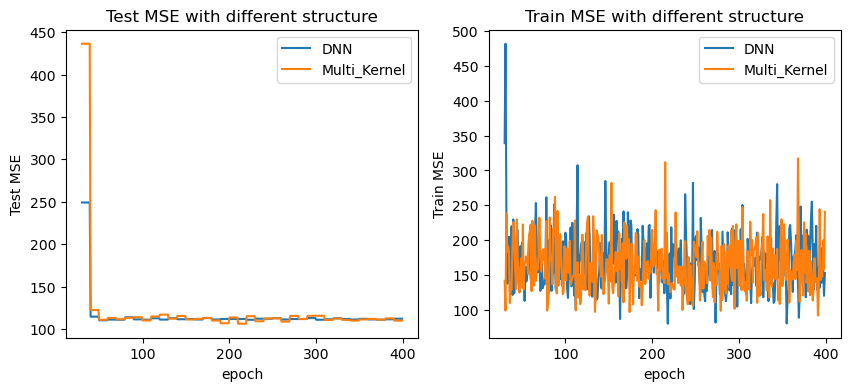

In [51]:
a=np.linspace(30,399,370)
epochset = [int(item) for item in a]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(epochset,dnn_testloss[30:])
ax[0].plot(epochset,kernelnn_testloss[30:])
ax[0].legend(["DNN","Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

ax[1].plot(epochset,dnn_trainloss[30:])
ax[1].plot(epochset,kernelnn_trainloss[30:])
ax[1].legend(["DNN","Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()

Resnet vs multilayer residual kernel

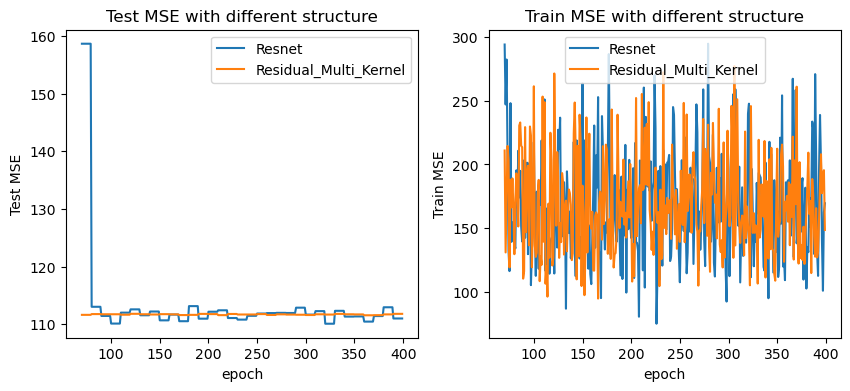

In [52]:
a=np.linspace(70,399,330)
epochset = [int(item) for item in a]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(epochset,res_testloss[70:])
ax[0].plot(epochset,reskernel_testloss[70:])
ax[0].legend(["Resnet","Residual_Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

ax[1].plot(epochset,res_trainloss[70:])
ax[1].plot(epochset,reskernel_trainloss[70:])
ax[1].legend(["Resnet","Residual_Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()

## residual learning

several parts with rotation

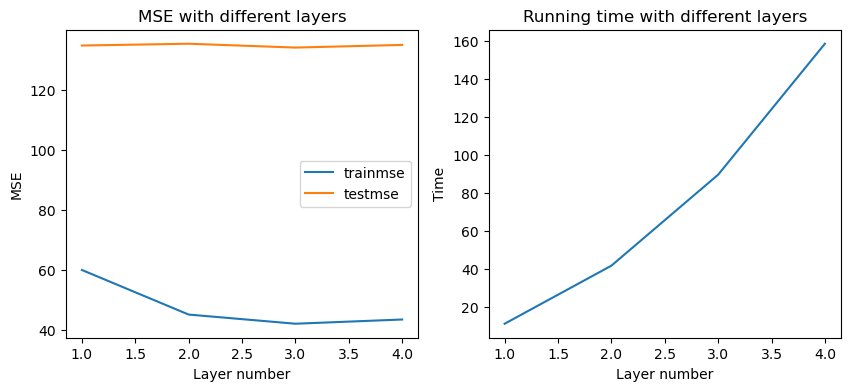

In [3]:
model =Ridge(alpha=1)
layerset=np.linspace(1,4,4)
layerset=layerset.astype(int)
m0=2000
gamma0=0.15
trainmse=[]
testmse=[]
t=[]
t0 = time.time()

for layer in layerset:
    length=int(len(train_x)/layer)
    split=10*layer
    for i in range(split):
        for l in range(layer):  
            lnew=(l+i)%layer
            if l==0:
                rff=RandomFourierFeature(90,int(m0/2**l),kernel='G',gamma=gamma0/2**l)
                total_x=pd.concat([train_x,test_x])
                feature=rff.transform(total_x)
                train_xtransformed=feature[:700]
                test_xtransformed=feature[700:]
                train_xltransformed=feature[lnew*length:(lnew+1)*length]
                    
                model.fit(train_xltransformed, train_y[lnew*length:(lnew+1)*length])
                ypre_test=model.predict(test_xtransformed)
                ypre_train=model.predict(train_xtransformed)
                
            else:
                rff=RandomFourierFeature(90,int(m0/2**l),kernel='C',gamma=gamma0/2**l)
                total_x=pd.concat([train_x,test_x])
                feature=rff.transform(total_x)
                train_xtransformed=feature[:700]
                test_xtransformed=feature[700:]
                train_xltransformed=feature[lnew*length:(lnew+1)*length]
                    
                model.fit(train_xltransformed, train_y[lnew*length:(lnew+1)*length]-ypre_train[lnew*length:(lnew+1)*length]) ##fit residual
                
                ypre_test=ypre_test+model.predict(test_xtransformed)
                ypre_train=ypre_train+model.predict(train_xtransformed)
        if i==0:
            yp_test=ypre_test
            yp_train=ypre_train
        else:
            yp_test=yp_test+ypre_test
            yp_train=yp_train+ypre_train
        
    yp_test=yp_test/split
    yp_train=yp_train/split
        
    
    kernel_fit = time.time() - t0
    
    t.append(kernel_fit)
    trainmse.append(mean_squared_error(train_y,yp_train))
    testmse.append(mean_squared_error(test_y,yp_test))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(layerset,trainmse)
ax[0].plot(layerset,testmse)
ax[0].legend(["trainmse","testmse"])
ax[0].set_xlabel("Layer number")
ax[0].set_ylabel("MSE")
ax[0].set_title("MSE with different layers")

ax[1].plot(layerset,t)
ax[1].set_xlabel("Layer number")
ax[1].set_ylabel("Time")
ax[1].set_title("Running time with different layers")
plt.show()

random shuffle: average

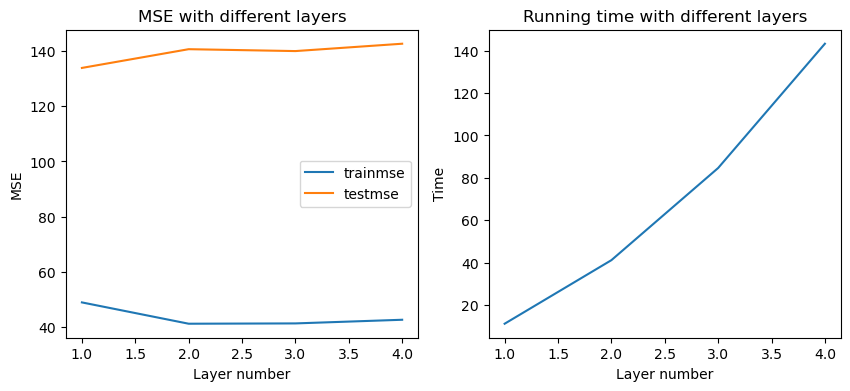

In [5]:
model =Ridge(alpha=1)
layerset=np.linspace(1,4,4)
layerset=layerset.astype(int)
m0=2000
gamma0=0.2
trainmse=[]
testmse=[]
t=[]
t0 = time.time()

for layer in layerset:
    length=int(len(train_x)/layer)
    split=10*layer
    for i in range(split):
        row_rand_array = np.arange(train_x.shape[0])
        np.random.shuffle(row_rand_array)
        for l in range(layer):  
            if l==0:
                rff=RandomFourierFeature(90,int(m0/2**l),kernel='G',gamma=gamma0*2**l)
                total_x=pd.concat([train_x,test_x])
                feature=rff.transform(total_x)
                train_xtransformed=feature[:700]
                test_xtransformed=feature[700:]
                train_xltransformed=feature[row_rand_array[l*length:(l+1)*length]]
                    
                model.fit(train_xltransformed, train_y.values[row_rand_array[l*length:(l+1)*length]])
                ypre_test=model.predict(test_xtransformed)
                ypre_train=model.predict(train_xtransformed)
                
            else:
                rff=RandomFourierFeature(90,int(m0/2**l),kernel='L',gamma=gamma0*2**l)
                total_x=pd.concat([train_x,test_x])
                feature=rff.transform(total_x)
                train_xtransformed=feature[:700]
                test_xtransformed=feature[700:]
                train_xltransformed=feature[row_rand_array[l*length:(l+1)*length]]
                    
                model.fit(train_xltransformed, train_y.values[row_rand_array[l*length:(l+1)*length]]-ypre_train[row_rand_array[l*length:(l+1)*length]]) ##fit residual
                
                ypre_test=ypre_test+model.predict(test_xtransformed)
                ypre_train=ypre_train+model.predict(train_xtransformed)
        if i==0:
            yp_test=ypre_test
            yp_train=ypre_train
        else:
            yp_test=yp_test+ypre_test
            yp_train=yp_train+ypre_train
        
    yp_test=yp_test/split
    yp_train=yp_train/split
        
    
    kernel_fit = time.time() - t0
    
    t.append(kernel_fit)
    trainmse.append(mean_squared_error(train_y,yp_train))
    testmse.append(mean_squared_error(test_y,yp_test))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(layerset,trainmse)
ax[0].plot(layerset,testmse)
ax[0].legend(["trainmse","testmse"])
ax[0].set_xlabel("Layer number")
ax[0].set_ylabel("MSE")
ax[0].set_title("MSE with different layers")

ax[1].plot(layerset,t)
ax[1].set_xlabel("Layer number")
ax[1].set_ylabel("Time")
ax[1].set_title("Running time with different layers")
plt.show()

random shuffle n/2

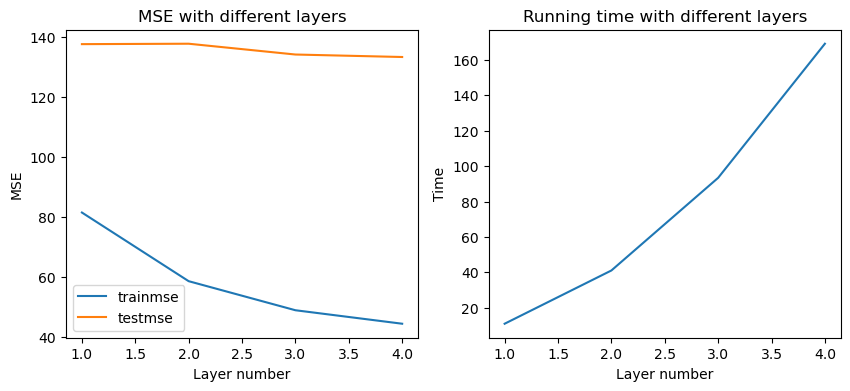

In [6]:
model =Ridge(alpha=1)
layerset=np.linspace(1,4,4)
layerset=layerset.astype(int)
m0=2000
gamma0=0.2
trainmse=[]
testmse=[]
t=[]
t0 = time.time()

for layer in layerset:
    length=int(len(train_x))
    split=10*layer
    for i in range(split):
        row_rand_array = np.arange(train_x.shape[0])
        np.random.shuffle(row_rand_array)
        for l in range(layer):  
            if l==0:
                rff=RandomFourierFeature(90,int(m0/2**l),kernel='G',gamma=gamma0*2**l)
                total_x=pd.concat([train_x,test_x])
                feature=rff.transform(total_x)
                train_xtransformed=feature[:700]
                test_xtransformed=feature[700:]
                train_xltransformed=feature[row_rand_array[int(length/2**(l+1)):int(length/2**l)]]
                    
                model.fit(train_xltransformed, train_y.values[row_rand_array[int(length/2**(l+1)):int(length/2**l)]])
                ypre_test=model.predict(test_xtransformed)
                ypre_train=model.predict(train_xtransformed)
                
            else:
                rff=RandomFourierFeature(90,int(m0/2**l),kernel='G',gamma=gamma0*2**l)
                total_x=pd.concat([train_x,test_x])
                feature=rff.transform(total_x)
                train_xtransformed=feature[:700]
                test_xtransformed=feature[700:]
                train_xltransformed=feature[row_rand_array[int(length/2**(l+1)):int(length/2**l)]]
                    
                model.fit(train_xltransformed, train_y.values[row_rand_array[int(length/2**(l+1)):int(length/2**l)]]-ypre_train[row_rand_array[int(length/2**(l+1)):int(length/2**l)]]) ##fit residual
                
                ypre_test=ypre_test+model.predict(test_xtransformed)
                ypre_train=ypre_train+model.predict(train_xtransformed)
        if i==0:
            yp_test=ypre_test
            yp_train=ypre_train
        else:
            yp_test=yp_test+ypre_test
            yp_train=yp_train+ypre_train
        
    yp_test=yp_test/split
    yp_train=yp_train/split
        
    
    kernel_fit = time.time() - t0
    
    t.append(kernel_fit)
    trainmse.append(mean_squared_error(train_y,yp_train))
    testmse.append(mean_squared_error(test_y,yp_test))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(layerset,trainmse)
ax[0].plot(layerset,testmse)
ax[0].legend(["trainmse","testmse"])
ax[0].set_xlabel("Layer number")
ax[0].set_ylabel("MSE")
ax[0].set_title("MSE with different layers")

ax[1].plot(layerset,t)
ax[1].set_xlabel("Layer number")
ax[1].set_ylabel("Time")
ax[1].set_title("Running time with different layers")
plt.show()